*Extra analysis performed utilizing the gtfs-kit library*. In particular, mapping the possible routes of a service. 

gtfs-kit
- [Documentation](https://mrcagney.github.io/gtfs_kit_docs/index.html)
- [Github](https://github.com/mrcagney/gtfs_kit/tree/master)
- [more gtfs links](https://gtfs.org/resources/visualizations/)

# Imports/Installation

In [1]:
import gtfs_kit as gk
import pandas as pd 
import folium
from geodatasets import get_path
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
import matplotlib.cm as cm
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 150

In [2]:
# Functions
def collect_shape_ids_for_route(feed, service: str):
    week = feed.get_first_week()
    dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday
    route_timetables = feed.build_route_timetable(service, dates)
    unique_shape_ids = route_timetables.drop_duplicates(subset=['route_id', 'service_id', 'shape_id'])
    # getting all routes in a dictionary
    shape_dict = {x: None for x in sorted(unique_shape_ids['shape_id'].unique())}
    for shape in shape_dict.keys():
        shape_id_example = unique_shape_ids[unique_shape_ids['shape_id']==shape]['trip_id']
        plot = feed.map_trips(trip_ids=shape_id_example, show_stops=True, show_direction=True)
        shape_dict[shape] = plot
    return shape_dict

def display_gk_plot(plot):
    fig = folium.Figure(width=800, height=500)
    fig.add_child(plot)
    return fig

def find_stop_pattern_variations_count(feed, trip_stats: pd. DataFrame, route_name: str):
    stop_name_dict = dict(zip(feed.stops['stop_id'], feed.stops['stop_name']))
    stop_pattern_count_df = pd.DataFrame(trip_stats[(trip_stats['route_id']=='5')].groupby('stop_pattern_name')['duration'].count()).reset_index().sort_values(by='duration', ascending=False)
    stop_pattern_variations_count_df = trip_stats[(trip_stats['route_id']=='5')].drop_duplicates(subset=['route_id', 'shape_id'])
    stop_pattern_variations_count_df['start_stop_id'] = stop_pattern_variations_count_df['start_stop_id'].replace(stop_name_dict)
    stop_pattern_variations_count_df['end_stop_id'] = stop_pattern_variations_count_df['end_stop_id'].replace(stop_name_dict)
    stop_pattern_variations_count_df = stop_pattern_variations_count_df.drop(columns=['trip_id', 'route_short_name', 'route_type', 'start_time', 'end_time', 'is_loop'])
    stop_pattern_variations_count_df = stop_pattern_variations_count_df.sort_values(by='start_stop_id')
    stop_pattern_name_dict = dict(zip(stop_pattern_count_df['stop_pattern_name'], stop_pattern_count_df['duration']))
    stop_pattern_variations_count_df['count_per_day'] = stop_pattern_variations_count_df['stop_pattern_name'].replace(stop_pattern_name_dict)
    return stop_pattern_variations_count_df

In [3]:
path_to_file = get_path('nybb')
boros = gpd.read_file(path_to_file).to_crs(epsg=3857)
boros = boros[boros['BoroName']!='Staten Island']

In [4]:
orig_stations_df = pd.read_csv("../data/MTA_Subway_Stations_20240325.csv")
orig_stations_df = orig_stations_df[orig_stations_df['Borough']!='SI'] 
orig_stations_df = orig_stations_df.drop(columns=['Division', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes'
                                                , 'North Direction Label', 'South Direction Label'])

In [5]:
orig_stations_df['GTFS Latitude'] = [x.split(" ")[1][1:] for x in orig_stations_df['Georeference']]
orig_stations_df['GTFS Longitude'] = [x.split(" ")[2][:-1] for x in orig_stations_df['Georeference']]
geometries = [shapely.Point(x,y) for x,y in list(zip(orig_stations_df['GTFS Latitude'], orig_stations_df['GTFS Longitude']))]
orig_stations_df['geometry'] = geometries
orig_stations_gdf = gpd.GeoDataFrame(orig_stations_df)
orig_stations_gdf = orig_stations_gdf.dissolve(by='Complex ID').reset_index()
orig_stations_gdf['geometry'] = orig_stations_gdf.geometry.centroid
orig_stations_gdf = orig_stations_gdf.set_crs(epsg=4326).to_crs(epsg=3857)
orig_stations_gdf = orig_stations_gdf.sort_values(by='Complex ID')

In [6]:
orig_stations_gdf

,Complex ID,geometry,GTFS Stop ID,Station ID,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,Georeference
0,1,POINT (-8227849.988 4979215.939),R01,1,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,-73.912034,40.775036,POINT (-73.912034 40.775036)
1,2,POINT (-8228496.643 4978513.603),R03,2,Astoria,Astoria Blvd,Q,N W,Elevated,-73.917843,40.770258,POINT (-73.917843 40.770258)
2,3,POINT (-8228901.401 4978002.243),R04,3,Astoria,30 Av,Q,N W,Elevated,-73.921479,40.766779,POINT (-73.921479 40.766779)
3,4,POINT (-8229349.907 4977273.391),R05,4,Astoria,Broadway,Q,N W,Elevated,-73.925508,40.76182,POINT (-73.925508 40.76182)
4,5,POINT (-8229802.644 4976536.218),R06,5,Astoria,36 Av,Q,N W,Elevated,-73.929575,40.756804,POINT (-73.929575 40.756804)
...,...,...,...,...,...,...,...,...,...,...,...,...
419,628,POINT (-8238514.869 4969673.408),M22,106,Jamaica,Fulton St,M,J Z,Subway,-74.007582,40.710374,POINT (-74.007582 40.710374)
420,629,POINT (-8232170.576 4970163.735),L10,121,Canarsie,Lorimer St,Bk,L,Subway,-73.950275,40.714063,POINT (-73.950275 40.714063)
421,630,POINT (-8227844.589 4968136.427),M08,112,Myrtle Av,Myrtle-Wyckoff Avs,Bk,M,Elevated,-73.912385,40.69943,POINT (-73.912385 40.69943)
422,635,POINT (-8239126.096 4968570.401),R27,23,Broadway,Whitehall St-South Ferry,M,R W,Subway,-74.012994,40.703087,POINT (-74.012994 40.703087)


# Using the Library


### Cleaning the Feed

In [7]:
path = "../data/google_transit"
# removing some rows with null start times
orig_feed = gk.read_feed(path, dist_units='mi')
feed = gk.miscellany.create_shapes(orig_feed, all_trips=True) 
feed.describe()
orig_stops = feed.stops

In [8]:
# removing some rows with null start times
#7 stops are removed, 1 route is removed (I don't see it though...) using feed.clean()
feed = feed.clean()
clean_stops = feed.stops
stop_name_dict = dict(zip(clean_stops['stop_id'], clean_stops['stop_name']))
feed.describe()

,indicator,value
0,agencies,[MTA New York City Transit]
1,timezone,America/New_York
2,start_date,20241215
3,end_date,20250117
4,num_routes,29
5,num_trips,20302
6,num_stops,1490
7,num_shapes,214
8,sample_date,20241219
9,num_routes_active_on_sample_date,29


In [9]:
# all of these stations do not have a location type...
removed_stops = set(orig_stops.stop_id.unique()).difference(set(clean_stops.stop_id.unique()))
# orig_stops[orig_stops['stop_id'].isin(removed_stops)]

In [10]:
# 214 shape variations!!
feed.trips['shape_id'].nunique()


214

In [11]:
# perfect except for num_stop_time_dists_missing which is because the MTA schedule is precise to only 30 seconds...
# gk.miscellany.assess_quality(feed)

In [12]:
# quick summary of all tables and their columns
gk.miscellany.summarize(feed).head()

,table,column,num_values,num_nonnull_values,num_unique_values,min_value,max_value
0,agency,agency_id,1,1,1,MTA_NYCT,MTA_NYCT
1,agency,agency_name,1,1,1,MTA New York City Transit,MTA New York City Transit
2,agency,agency_url,1,1,1,http://www.mta.info,http://www.mta.info
3,agency,agency_timezone,1,1,1,America/New_York,America/New_York
4,agency,agency_lang,1,1,1,en,en


In [13]:
# Getting the Representative days for the analysis
# note: pre-planned service changes have the correct day (e.g.: New Years Day has Sunday Service)
week = feed.get_first_week()
dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday

### Computing Trip/Route Stats

In [14]:
# for all days
trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,4,312,684,6,314
trip_id,AFA24GEN-1038-Sunday-00_007200_1..N03R,AFA24GEN-1039-Saturday-00_007200_1..N03R,AFA24GEN-1093-Weekday-00_007450_1..N03R,AFA24GEN-1038-Sunday-00_009200_1..N03R,AFA24GEN-1039-Saturday-00_009200_1..N03R
route_id,1,1,1,1,1
route_short_name,1,1,1,1,1
route_type,1,1,1,1,1
direction_id,0,0,0,0,0
shape_id,shape_006,shape_006,shape_006,shape_006,shape_006
stop_pattern_name,0-1,0-1,0-1,0-1,0-1
num_stops,38,38,38,38,38
start_time,01:12:00,01:12:00,01:14:30,01:32:00,01:32:00
end_time,02:10:30,02:10:30,02:12:30,02:30:30,02:30:30


In [15]:
fts = feed.compute_feed_time_series((trip_stats), dates, freq='1h').round(2)
fts

indicator,num_trip_ends,num_trip_starts,num_trips,service_distance,service_duration,service_speed
datetime,,,,,,
2024-12-20 00:00:00,46.0,146.0,174.0,2345.11,153.35,15.29
2024-12-20 01:00:00,122.0,133.0,232.0,1874.40,123.92,15.13
2024-12-20 02:00:00,131.0,130.0,240.0,1738.81,115.57,15.05
2024-12-20 03:00:00,130.0,130.0,239.0,1737.56,115.43,15.05
2024-12-20 04:00:00,129.0,141.0,250.0,1803.56,118.67,15.20
...,...,...,...,...,...,...
2024-12-22 19:00:00,298.0,281.0,535.0,4038.12,249.18,16.21
2024-12-22 20:00:00,274.0,262.0,500.0,3849.14,236.20,16.30
2024-12-22 21:00:00,258.0,243.0,471.0,3687.06,225.08,16.38


## Plots of Service by Day Type

<Axes: xlabel='datetime'>

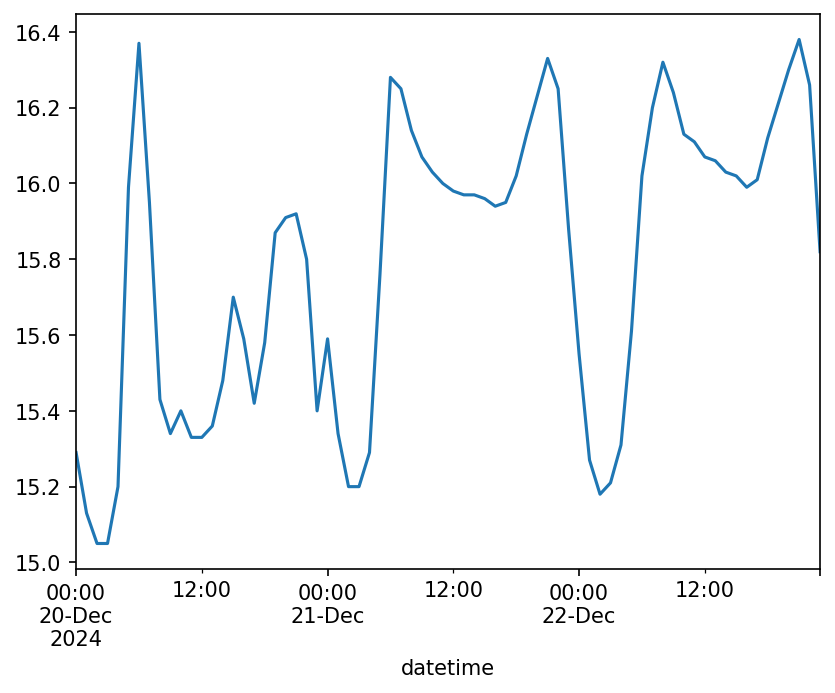

In [16]:
# speed, especially at late nights, depends on how "local" the services are
fts['service_speed'].plot()

<Axes: xlabel='datetime'>

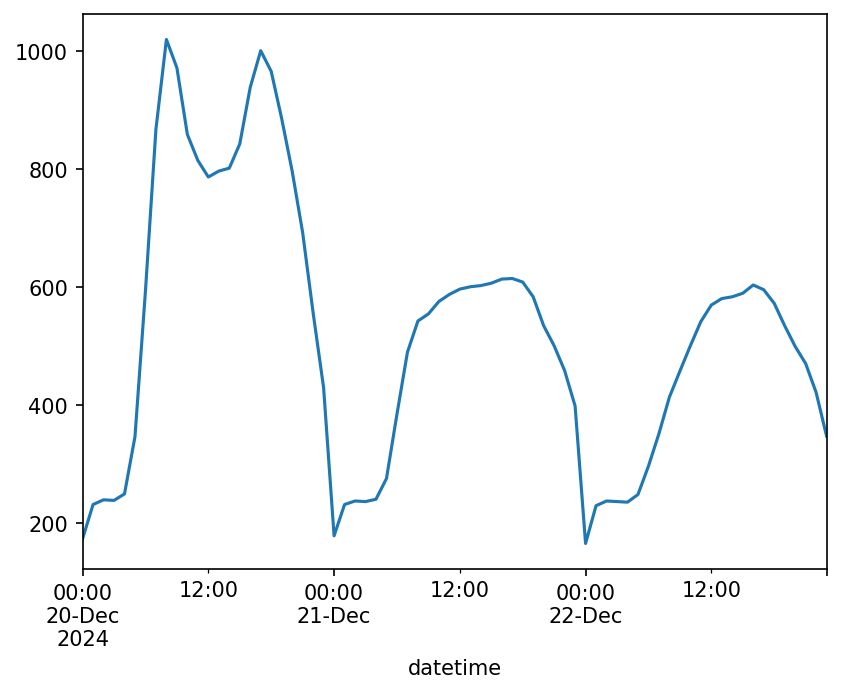

In [17]:
fts['num_trips'].plot()

## Route Timetables

In [18]:
# possible routes feed.routes['route_id'].unique()
route_id = 'L'
route_timetables_L = feed.build_route_timetable(route_id, dates)
route_timetables_L.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
407695,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241220
407696,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L28N,00:08:00,00:08:00,2,20241220
407697,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L27N,00:10:00,00:10:00,3,20241220
407698,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L26N,00:11:30,00:11:30,4,20241220
407699,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L25N,00:13:00,00:13:00,5,20241220


In [19]:
# getting one trip_id per shape_id
unique_shape_ids = route_timetables_L.drop_duplicates(subset=['route_id', 'shape_id'])
# Getting all Shape IDs in one file 
print(f"There are {route_timetables_L['shape_id'].nunique()} unique routes for the {route_id}")
unique_shape_ids

There are 5 unique routes for the L


,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
407695,L,BFA24GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_173,L29N,00:06:30,00:06:30,1,20241220
407791,L,BFA24GEN-L049-Weekday-00_005400_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_170,L01S,00:54:00,00:54:00,1,20241220
408487,L,BFA24GEN-L049-Weekday-00_031950_L..N02R,Weekday,8 Av,0,shape_172,L28N,05:19:30,05:19:30,1,20241220
409581,L,BFA24GEN-L049-Weekday-00_045300_L..S05R,Weekday,Myrtle-Wyckoff Avs,1,shape_169,L01S,07:33:00,07:33:00,1,20241220
410003,L,BFA24GEN-L049-Weekday-00_048750_L..N05R,Weekday,8 Av,0,shape_171,L17N,08:07:30,08:07:30,1,20241220


## Trip Stats

In [20]:
friday = [week[4]]
trip_information_fri = feed.compute_route_stats(trip_stats, friday)
# I don't trust the peak information
trip_information_fri = trip_information_fri.drop(columns=['route_short_name', 'date', 'peak_num_trips', 'is_bidirectional'
                                                          ,'route_type', 'is_loop', 'peak_start_time', 'peak_end_time', 'min_headway'])
trip_information_fri = trip_information_fri.round(1)
trip_information_fri.head(10)

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
0,1,462,462,446,6,00:06:30,25:57:00,9.0,4.8,6634.2,433.6,15.3,14.4,0.9
1,2,324,324,301,7,00:19:00,27:40:30,13.0,7.1,7929.2,541.2,14.7,24.5,1.7
2,3,304,304,300,5,00:02:30,24:48:00,12.5,7.4,4750.1,314.5,15.1,15.6,1.0
3,4,370,370,351,21,00:05:30,27:06:00,11.5,6.1,7362.9,445.0,16.5,19.9,1.2
4,5,329,329,328,29,00:02:00,24:16:00,14.0,6.5,6337.1,391.1,16.2,19.3,1.2
5,6,439,439,419,6,00:07:00,26:06:00,10.5,5.0,5854.2,417.2,14.0,13.3,1.0
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,7.3,1582.0,111.4,14.2,14.0,1.0
7,7,535,535,520,5,00:11:30,25:23:30,10.0,4.2,5206.5,341.9,15.2,9.7,0.6
8,7X,107,107,107,2,06:15:00,22:15:30,10.0,5.7,1052.5,65.9,16.0,9.8,0.6
9,A,375,375,351,22,00:11:30,27:49:00,16.0,6.6,9342.5,521.2,17.9,24.9,1.4


In [21]:
# to get the headway for this I'll need to include avg trip duration for each route 
gk.routes.compute_route_time_series_0(trip_stats, friday[0], split_directions=False, freq='60Min')['num_trips'].head()

route_id,1,2,3,4,5,6,6X,7,7X,A,...,H,J,L,M,N,Q,R,SI,W,Z
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-20 00:00:00,25,35,17,32,18,27,0,25,0,44,...,16,18,27,21,28,21,18,12,0,0
2024-12-20 01:00:00,44,37,24,42,18,46,0,36,0,58,...,21,36,39,18,33,36,27,18,0,0
2024-12-20 02:00:00,37,52,24,48,18,38,0,27,0,69,...,18,36,30,18,42,36,27,18,0,0
2024-12-20 03:00:00,36,52,24,48,18,37,0,27,0,69,...,18,36,30,18,42,36,27,18,0,0
2024-12-20 04:00:00,37,53,24,50,19,38,0,30,0,70,...,18,36,31,18,42,37,27,18,0,0


In [25]:
## this ignores trips that end after 24:00
# trip_information_fri.sort_values(by='num_trip_ends')
service_speed_df = trip_information_fri.sort_values(by='service_speed')
service_speed_df.to_csv("../saved_data/service_speed_comparison.csv")
service_speed_df

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
15,FS,238,238,238,2,00:00:00,23:56:30,10.0,10.0,321.8,26.8,12.0,1.4,0.1
27,W,187,187,187,4,06:13:00,22:55:30,17.5,9.7,1805.4,138.3,13.1,9.7,0.7
25,R,303,303,297,9,00:15:00,25:17:00,11.5,7.5,5676.4,409.8,13.9,18.7,1.4
5,6,439,439,419,6,00:07:00,26:06:00,10.5,5.0,5854.2,417.2,14.0,13.3,1.0
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,7.3,1582.0,111.4,14.2,14.0,1.0
22,M,292,292,290,6,00:00:00,24:18:00,11.0,7.9,4150.6,291.2,14.3,14.2,1.0
20,J,287,287,276,9,00:08:30,25:47:30,13.5,7.8,3646.7,247.9,14.7,12.7,0.9
1,2,324,324,301,7,00:19:00,27:40:30,13.0,7.1,7929.2,541.2,14.7,24.5,1.7
2,3,304,304,300,5,00:02:30,24:48:00,12.5,7.4,4750.1,314.5,15.1,15.6,1.0
7,7,535,535,520,5,00:11:30,25:23:30,10.0,4.2,5206.5,341.9,15.2,9.7,0.6


## Stop Patterns

In [20]:
stop_patterns_fri = trip_information_fri[['route_id', 'num_stop_patterns']]
stop_patterns_fri.columns = ['route_id', 'num_stop_patterns_fri']

In [21]:
sat = [week[5]]
trip_information_sat = feed.compute_route_stats(trip_stats, sat)
stop_patterns_sat = trip_information_sat[['route_id', 'num_stop_patterns']]
stop_patterns_sat.columns = ['route_id', 'num_stop_patterns_sat']


In [22]:
sun = [week[6]]
trip_information_sun = feed.compute_route_stats(trip_stats, sun)
stop_patterns_sun = trip_information_sun[['route_id', 'num_stop_patterns']]
stop_patterns_sun.columns = ['route_id', 'num_stop_patterns_sun']

In [23]:
# all trip_patterns by day of week
## should adjust so that the routes that don't run every day are shown as null in the weekends
stop_patterns_by_day = stop_patterns_fri.merge(stop_patterns_sat).merge(stop_patterns_sun)
stop_patterns_by_day.head(5)

,route_id,num_stop_patterns_fri,num_stop_patterns_sat,num_stop_patterns_sun
0,1,6,2,2
1,2,7,4,4
2,3,5,4,4
3,4,21,10,8
4,5,29,4,4


In [48]:
# the Z has 6 trips with different stopping patterns
# I think the stop patterns are for number of variations of each direction shape
## e.g.: 0-1 is the most popular stop pattern going south, 0-2 is 2nd most popular, etc...
stop_pattern_count_5 = pd.DataFrame(trip_stats[(trip_stats['route_id']=='5')].groupby('stop_pattern_name')['duration'].count()).reset_index().sort_values(by='duration', ascending=False)
stop_patterns_5 = trip_stats[(trip_stats['route_id']=='5')].drop_duplicates(subset=['route_id', 'shape_id'])
stop_patterns_5['start_stop_id'] = stop_patterns_5['start_stop_id'].replace(stop_name_dict)
stop_patterns_5['end_stop_id'] = stop_patterns_5['end_stop_id'].replace(stop_name_dict)
stop_patterns_5 = stop_patterns_5.drop(columns=['trip_id', 'route_short_name', 'route_type', 'start_time', 'end_time', 'is_loop'])
stop_patterns_5 = stop_patterns_5.sort_values(by='start_stop_id')
stop_pattern_name_dict = dict(zip(stop_pattern_count_5['stop_pattern_name'], stop_pattern_count_5['duration']))
stop_patterns_5['count_per_day'] = stop_patterns_5['stop_pattern_name'].replace(stop_pattern_name_dict)
stop_patterns_5

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_55410/1224442914.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stop_patterns_5['count_per_day'] = stop_patterns_5['stop_pattern_name'].replace(stop_pattern_name_dict)


,route_id,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,count_per_day
4390,5,0,shape_059,0-15,18,Bowling Green,Eastchester-Dyre Av,1.033333,16.448417,15.917823,1
3709,5,0,shape_060,0-1,25,Bowling Green,Eastchester-Dyre Av,0.900000,16.755373,18.617081,183
4232,5,0,shape_057,0-7,14,Bowling Green,Gun Hill Rd,0.900000,15.047751,16.719724,3
4242,5,0,shape_056,0-9,13,Bowling Green,E 180 St,0.725000,12.538604,17.294627,2
4379,5,0,shape_058,0-12,22,Bowling Green,Nereid Av,1.091667,16.638169,15.241070,2
4229,5,0,shape_027,0-11,18,Crown Hts-Utica Av,E 180 St,1.058333,17.669890,16.695959,2
4370,5,0,shape_028,0-8,27,Crown Hts-Utica Av,Nereid Av,1.333333,21.769454,16.327091,3
4355,5,0,shape_029,0-6,23,Crown Hts-Utica Av,Eastchester-Dyre Av,1.291667,21.579703,16.706867,5
4244,5,1,shape_015,1-8,20,E 180 St,Bowling Green,0.841667,12.845560,15.262052,3
4212,5,1,shape_018,1-14,13,E 180 St,Bowling Green,0.833333,12.538604,15.046325,1


In [49]:
stop_patterns_5 = find_stop_pattern_variations_count(feed, trip_stats, 5)
stop_patterns_5.sort_values(by='count_per_day').head(10)

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_55410/1425705073.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stop_pattern_variations_count_df['count_per_day'] = stop_pattern_variations_count_df['stop_pattern_name'].replace(stop_pattern_name_dict)


,route_id,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,count_per_day
4390,5,0,shape_059,0-15,18,Bowling Green,Eastchester-Dyre Av,1.033333,16.448417,15.917823,1
4212,5,1,shape_018,1-14,13,E 180 St,Bowling Green,0.833333,12.538604,15.046325,1
4174,5,0,shape_035,0-13,39,New Lots Av,Eastchester-Dyre Av,1.433333,24.627197,17.181765,1
4214,5,1,shape_011,1-13,22,Nereid Av,Bowling Green,1.183333,16.638169,14.060424,1
4200,5,0,shape_033,0-14,37,New Lots Av,Eastchester-Dyre Av,1.541667,24.626482,15.973934,1
4334,5,1,shape_017,1-12,25,E 180 St,Crown Hts-Utica Av,1.050000,17.976846,17.120806,2
4229,5,0,shape_027,0-11,18,Crown Hts-Utica Av,E 180 St,1.058333,17.669890,16.695959,2
4242,5,0,shape_056,0-9,13,Bowling Green,E 180 St,0.725000,12.538604,17.294627,2
4195,5,1,shape_068,1-9,23,Eastchester-Dyre Av,Crown Hts-Utica Av,1.250000,21.579703,17.263762,2
4205,5,0,shape_021,0-10,31,Flatbush Av-Brooklyn College,E 180 St,1.233333,19.508913,15.818038,2


In [68]:
## new lots avenue is only a start station
# stop_patterns_5['start_stop_id'].unique()
## gun hill road is only an end station
# stop_patterns_5['end_stop_id'].unique()

## Duration by shape ID

In [51]:
duration_by_shape = trip_stats.groupby(['route_id', 'stop_pattern_name', 'shape_id']).mean('duration')
duration_by_shape_no_S = duration_by_shape.reset_index()[~duration_by_shape.reset_index().route_id.isin(['FS', 'GS', 'H'])]

In [52]:
# A has the longest service (barely beating the 2)
# Ironically the A shuttle (lefferts branch late night) is the shortest non-shuttle
# duration_by_shape.sort_values(by='duration')
duration_by_shape_no_S.sort_values(by='duration')


,route_id,stop_pattern_name,shape_id,route_type,direction_id,num_stops,is_loop,duration,distance,speed
100,A,1-4,shape_098,1.0,1.0,8.0,0.0,0.181921,2.572688,14.146105
88,A,0-4,shape_100,1.0,0.0,8.0,0.0,0.182051,2.572688,14.140791
61,5,1-2,shape_062,1.0,1.0,6.0,0.0,0.183333,3.909813,21.326253
47,5,0-2,shape_014,1.0,0.0,6.0,0.0,0.199706,3.909813,19.581921
172,M,1-3,shape_177,1.0,1.0,8.0,0.0,0.210759,2.721544,12.931973
...,...,...,...,...,...,...,...,...,...,...
8,2,0-3,shape_037,1.0,0.0,52.0,0.0,1.766667,25.640054,14.528407
10,2,1-2,shape_007,1.0,1.0,61.0,0.0,1.770912,24.480237,13.848050
87,A,0-3,shape_163,1.0,0.0,59.0,0.0,1.786538,31.088137,17.401853
11,2,1-3,shape_009,1.0,1.0,52.0,0.0,1.795000,25.640054,14.294815


In [53]:
# the 2 has the most stops (61)
duration_by_shape.sort_values(by='num_stops')
duration_by_shape_no_S.sort_values(by=['num_stops', 'route_id'])[0:15]

,route_id,stop_pattern_name,shape_id,route_type,direction_id,num_stops,is_loop,duration,distance,speed
47,5,0-2,shape_014,1.0,0.0,6.0,0.0,0.199706,3.909813,19.581921
61,5,1-2,shape_062,1.0,1.0,6.0,0.0,0.183333,3.909813,21.326253
88,A,0-4,shape_100,1.0,0.0,8.0,0.0,0.182051,2.572688,14.140791
100,A,1-4,shape_098,1.0,1.0,8.0,0.0,0.181921,2.572688,14.146105
169,M,0-3,shape_174,1.0,0.0,8.0,0.0,0.211181,2.721544,12.905473
172,M,1-3,shape_177,1.0,1.0,8.0,0.0,0.210759,2.721544,12.931973
199,R,1-3,shape_201,1.0,1.0,8.0,0.0,0.216667,3.065401,14.148006
14,3,0-2,shape_003,1.0,0.0,9.0,0.0,0.366546,5.859247,16.129646
16,3,1-2,shape_041,1.0,1.0,9.0,0.0,0.361957,5.859247,16.319141
206,SI,1-2,shape_211,2.0,1.0,10.0,0.0,0.555263,13.628672,24.555831


### Do Any Shape IDs Have a Start and End Terminal Pair Used by Two Services?

In [176]:
unique_shape_ids = trip_stats.drop_duplicates(['route_id', 'stop_pattern_name', 'shape_id'])
unique_shape_ids = unique_shape_ids.drop(columns=['trip_id', 'start_time', 'end_time', 'is_loop']).round(2).reset_index(drop=True)
unique_shape_ids['start_end_stop_id'] = [unique_shape_ids['start_stop_id'].iloc[x] + '-' + unique_shape_ids['end_stop_id'].iloc[x] for x in range(len(unique_shape_ids))]
unique_shape_ids['start_end_stop_id_count'] = unique_shape_ids.groupby(['start_end_stop_id', 'direction_id'])['start_end_stop_id'].transform('count')

In [177]:
multi_used_start_end_stops = unique_shape_ids[unique_shape_ids['start_end_stop_id_count']>1].sort_values(by='start_end_stop_id')
multi_used_start_end_stops

,route_id,route_short_name,route_type,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,start_end_stop_id,start_end_stop_id_count
9,2,2,1,1,shape_007,1-2,61,201S,247S,1.74,24.48,14.06,201S-247S,2
10,2,2,1,1,shape_008,1-1,49,201S,247S,1.56,24.43,15.68,201S-247S,2
11,2,2,1,1,shape_010,1-4,48,204S,247S,1.54,24.05,15.60,204S-247S,2
60,5,5,1,1,shape_012,1-5,33,204S,247S,1.45,23.30,16.07,204S-247S,2
63,5,5,1,1,shape_018,1-14,13,213S,420S,0.83,12.54,15.05,213S-420S,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,N,N,1,1,shape_195,1-6,35,R01S,D43S,1.25,19.53,15.62,R01S-D43S,6
201,SI,SIR,2,0,shape_207,0-1,21,S09N,S31N,0.70,14.20,20.28,S09N-S31N,2
202,SI,SIR,2,0,shape_208,0-2,13,S09N,S31N,0.60,13.82,23.04,S09N-S31N,2
205,SI,SIR,2,1,shape_213,1-1,21,S31S,S09S,0.70,14.20,20.28,S31S-S09S,2


In [206]:
multi_service_start_end_stops = multi_used_start_end_stops.groupby(['start_end_stop_id', 'route_id']).count().reset_index()
multi_service_start_end_stops_ids = multi_service_start_end_stops[multi_service_start_end_stops.duplicated(subset='start_end_stop_id')]['start_end_stop_id']

In [ ]:
# which start_end_stop_ids have multiple different routes
start_end_stop_duplicates_diff_services = multi_service_start_end_stops[multi_service_start_end_stops['start_end_stop_id'].isin(multi_service_start_end_stops_ids)]

In [214]:
duplicated_pivot = start_end_stop_duplicates_diff_services.pivot(index='start_end_stop_id', columns='route_id', values='route_short_name')
duplicated_pivot

route_id,2,5,6,6X,7,7X,F,FX,J,N,Q,W,Z
start_end_stop_id,,,,,,,,,,,,,
204S-247S,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601S-640S,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640N-601N,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701S-726S,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726N-701N,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D43N-F01N,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN
D43N-Q05N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN
F01S-D43S,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
G05S-M23S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0


In [249]:
duplicated_dict_all_values = dict(duplicated_pivot.T)
# removing nulls
duplicated_dict = {}
for key, value in duplicated_dict_all_values.items():
    new_value = dict(value[value.values>0])
    duplicated_dict[str(key)] = new_value.keys()


In [254]:
# removing duplicates that are just local/express 
# 4 different start and stop pairs are the same route but different services
# the N and Q have one that's in both directions
interesting_keys = {'204S-247S', 'D43N-Q05N', 'N10N-R01N', 'Q05S-D43S'}
interesting_duplicated_dict_shapes = {key: duplicated_dict[key] for key in interesting_keys}
interesting_duplicated_dict_shapes

{'204S-247S': dict_keys(['2', '5']),
 'D43N-Q05N': dict_keys(['N', 'Q']),
 'Q05S-D43S': dict_keys(['N', 'Q']),
 'N10N-R01N': dict_keys(['N', 'W'])}

In [260]:
unique_shape_ids[unique_shape_ids['start_end_stop_id'].isin(interesting_duplicated_dict_shapes.keys())].sort_values(by='start_end_stop_id')

,route_id,route_short_name,route_type,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,start_end_stop_id,start_end_stop_id_count
11,2,2,1,1,shape_010,1-4,48,204S,247S,1.54,24.05,15.60,204S-247S,2
60,5,5,1,1,shape_012,1-5,33,204S,247S,1.45,23.30,16.07,204S-247S,2
179,N,N,1,0,shape_125,0-6,22,D43N,Q05N,1.07,17.31,16.23,D43N-Q05N,3
187,Q,Q,1,0,shape_120,0-2,34,D43N,Q05N,1.10,17.31,15.73,D43N-Q05N,3
188,Q,Q,1,0,shape_119,0-1,29,D43N,Q05N,1.02,17.29,16.87,D43N-Q05N,3
177,N,N,1,0,shape_184,0-5,27,N10N,R01N,1.12,18.45,16.52,N10N-R01N,2
208,W,W,1,0,shape_185,0-2,44,N10N,R01N,1.41,19.47,13.83,N10N-R01N,2
185,N,N,1,1,shape_189,1-5,22,Q05S,D43S,1.07,17.31,16.23,Q05S-D43S,3
189,Q,Q,1,1,shape_186,1-2,34,Q05S,D43S,1.09,17.31,15.85,Q05S-D43S,3
190,Q,Q,1,1,shape_188,1-1,29,Q05S,D43S,1.03,17.29,16.73,Q05S-D43S,3


### Mapping one of the routes

In [54]:
shape_ids_R = collect_shape_ids_for_route(feed, 'R')
print(shape_ids_R.keys())
plot = display_gk_plot(shape_ids_R['shape_199'])
plot

dict_keys(['shape_155', 'shape_156', 'shape_199', 'shape_200', 'shape_201', 'shape_202', 'shape_203', 'shape_204', 'shape_205'])


In [55]:
# 6 trains all go to either 3rd ave-e 180th st, parkchester or Pelham Bay Park
shape_ids_6 = collect_shape_ids_for_route(feed, '6')
print(shape_ids_6.keys())
plot = display_gk_plot(shape_ids_6['shape_069'])
plot

dict_keys(['shape_069', 'shape_071', 'shape_072', 'shape_073', 'shape_075', 'shape_076'])


In [56]:
# 6X trains all go from 3rd ave-e 180th st to hunts pt ave, to parkchester and then local 
shape_ids_6X = collect_shape_ids_for_route(feed, '6X')
print(shape_ids_6X.keys())
plot = display_gk_plot(shape_ids_6X['shape_074'])
plot

dict_keys(['shape_070', 'shape_074'])


## Heatmap of all of the stations a service touches 

In [ ]:
# folium/geopandas map where every time a station is served by a service it gets slightly darker
## this will show which stations are in the core of the route and which ones are marginal
## I can use the percent of trips that touch that station to show darkness 

In [18]:
stop_times_adjusted = feed.stop_times.copy()
stop_times_adjusted['stop_id'] = [x[:-1] for x in stop_times_adjusted['stop_id']]
stop_times_adjusted = stop_times_adjusted.merge(feed.trips, on='trip_id')

In [19]:
# counts of the number of times a route serves a stop on a weekday
station_route_count_df = pd.DataFrame(stop_times_adjusted[stop_times_adjusted['service_id']=='Weekday'].groupby(['stop_id', 'route_id'])['trip_id'].count()).reset_index()
station_route_count_df.columns = ['stop_id', 'service', 'count']

In [50]:
service_total_num_stops = dict(station_route_count_df.groupby('service')['count'].sum())
pct_of_total_service_at_stop = []
for idx in range(len(station_route_count_df)):
    service_id = station_route_count_df['service'].iloc[idx]
    service_total = service_total_num_stops[service_id]
    pct_of_total = round((station_route_count_df['count'].iloc[idx]/service_total)* 100, 2) 
    pct_of_total_service_at_stop.append(pct_of_total)
station_route_count_df['percent_of_total'] = pct_of_total_service_at_stop

In [51]:
station_route_count_df

,stop_id,service,count,percent_of_total
0,101,1,431,2.48
1,103,1,446,2.56
2,104,1,446,2.56
3,106,1,446,2.56
4,107,1,452,2.60
...,...,...,...,...
1018,S27,SI,121,4.51
1019,S28,SI,121,4.51
1020,S29,SI,121,4.51
1021,S30,SI,121,4.51


In [64]:
station_route_count_df_wide = station_route_count_df.pivot(index='stop_id', columns='service', values='percent_of_total').reset_index()
orig_stations_gdf = orig_stations_gdf.merge(station_route_count_df_wide, left_on='GTFS Stop ID', right_on='stop_id')

In [94]:
vcenter = 0.01
vmin, vmax = orig_stations_gdf['5'].min(), orig_stations_gdf['5'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.Reds

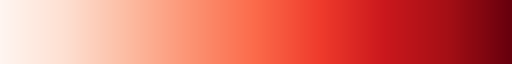

In [102]:
colormap

In [121]:
normalize

TypeError: Normalize.__call__() missing 1 required positional argument: 'value'

In [111]:
orig_stations_gdf_single_service[service_to_map]

276    2.65
280    0.01
281    0.01
282    0.28
283    0.02
284    0.02
285    0.02
286    0.02
287    0.02
288    0.02
289    0.02
290    2.36
291    2.36
292    2.36
293    2.36
294    2.36
295    2.36
296    2.36
326    2.99
327    2.99
332    2.99
340    2.99
341    2.99
343    0.26
344    0.26
345    0.26
346    0.26
347    0.29
348    0.26
349    0.26
350    0.26
351    0.26
352    3.57
353    2.15
354    2.15
355    2.15
356    2.15
357    2.15
358    2.15
359    2.15
360    2.99
367    3.10
368    3.10
369    3.10
370    3.10
371    3.10
401    2.99
Name: 5, dtype: float64

<Axes: title={'center': 'Stations Served by the 2 Train'}>

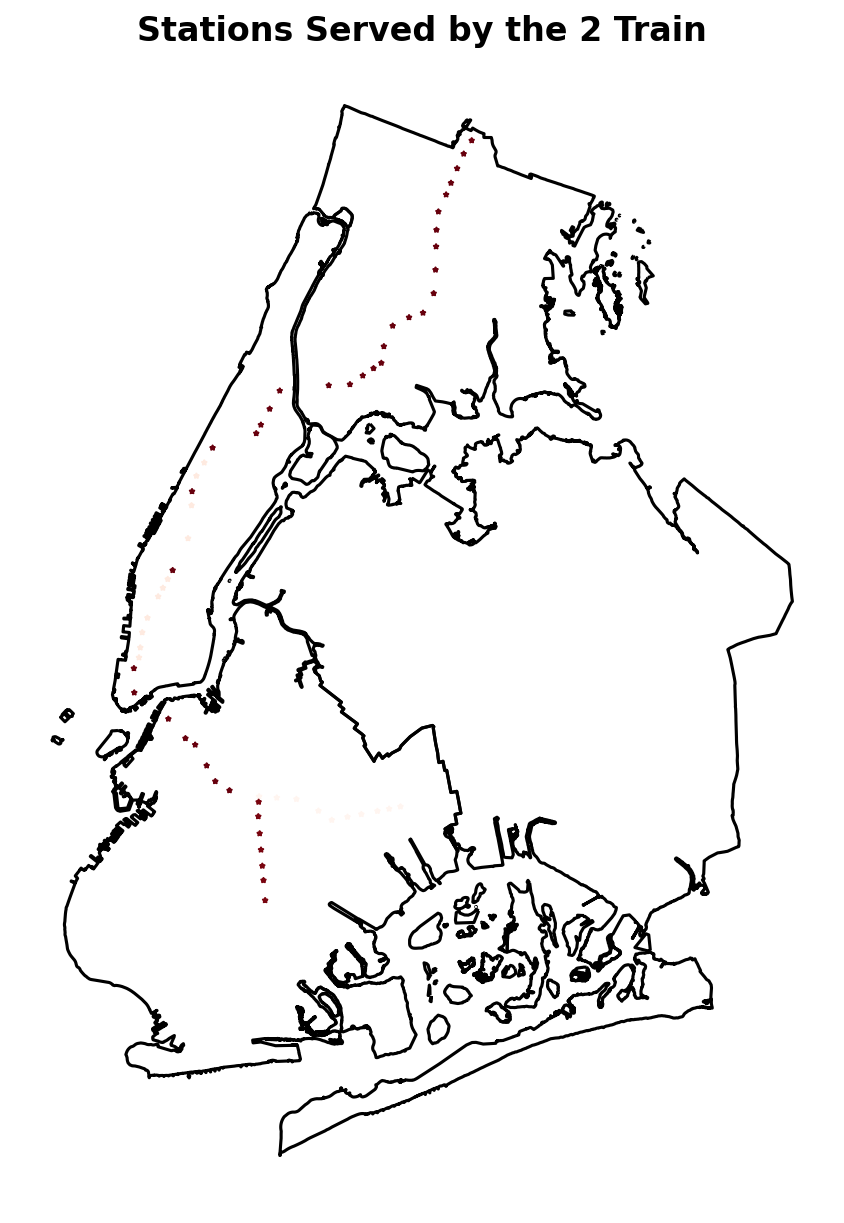

In [136]:
service_to_map = '2'
orig_stations_gdf_single_service = orig_stations_gdf[orig_stations_gdf[service_to_map]>0]

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.set_title(f"Stations Served by the {service_to_map} Train", color='black', fontsize=16, weight='bold')
boros.boundary.plot(ax=ax, color="black")

vmin, vmax = orig_stations_gdf_single_service[service_to_map].min(), orig_stations_gdf_single_service[service_to_map].max()
vcenter = vmin + 0.01
normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
colormap = cm.Reds
# stations
# orig_stations_gdf_single_service['geometry'].plot(marker='*', markersize=5, ax=ax, aspect='auto')
orig_stations_gdf_single_service.plot(column=service_to_map, cmap=cm.Reds, norm=normalize, marker='*', markersize=5, ax=ax, )